In [1]:
import numpy as np
import os

import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

import random

import matplotlib.pyplot as plt
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
from torchvision.utils import make_grid
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
# Parameters
img_size = 128
batch_size = 128
data_variance = 1
device = "mps"

# Training Parameters
n_epochs = 50
learning_rate = 0.001
decay = 0.0

# ConvNet Parameters
num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2
embedding_dim = 64
num_embeddings = 512
commitment_cost = 0.25

In [3]:
def load_image_names(file_path):
    with open(file_path, 'r') as f:
        return [line.strip() for line in f]

In [4]:
root_dir = "celeba_gan/"
names = load_image_names("./" + root_dir + "list_eval_partition.txt")

In [5]:
# Stack image names with the corresponding partition offset
train_files, valid_files, test_files = [], [], []

for name in names:
    if name[-1] == "0":
        train_files.append(name[:-2])
    elif name[-1] == "1":
        valid_files.append(name[:-2])
    elif name[-1] == "2":
        test_files.append(name[:-2])

In [6]:
# Build a custom dataset
class CustomDataset(datasets.ImageFolder):
    def __init__(self, root, file_list, transform=None):
        super().__init__(root, transform)
        self.file_list = set(file_list)
        self.samples = [s for s in self.samples if os.path.basename(s[0]) in self.file_list]
        self.targets = [s[1] for s in self.samples]

    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target

In [7]:
# Custom normalization function to scale tensor to [a, b]
class NormalizeToRange:
    def __init__(self, a, b):
        self.a = a
        self.b = b

    def __call__(self, tensor):
        min_val = torch.min(tensor)
        max_val = torch.max(tensor)
        tensor = (tensor - min_val) / (max_val - min_val)  # Scale to [0, 1]
        tensor = tensor * (self.b - self.a) + self.a  # Scale to [a, b]
        return tensor

In [8]:
transform_train = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    NormalizeToRange(a=-1, b=1)
])

transform_non_train = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    NormalizeToRange(a=-1, b=1)
])

In [9]:
dataset_train = CustomDataset(root=root_dir, file_list=train_files, transform=transform_train)
dataset_valid = CustomDataset(root=root_dir, file_list=valid_files, transform=transform_non_train)
dataset_test = CustomDataset(root=root_dir, file_list=test_files, transform=transform_non_train)

In [10]:
def randomlyLoadNImages(dataset, N_INSTANCES):
    
    # Create dataloader using a subset of the dataset
    indices = np.random.permutation(N_INSTANCES)
    sampler = SubsetRandomSampler(indices)
    return torch.utils.data.DataLoader(dataset, batch_size, sampler=sampler)

dataloader_train = randomlyLoadNImages(dataset_train, 10000)
dataloader_valid = randomlyLoadNImages(dataset_valid, 1250)
dataloader_test = randomlyLoadNImages(dataset_test, 1250)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


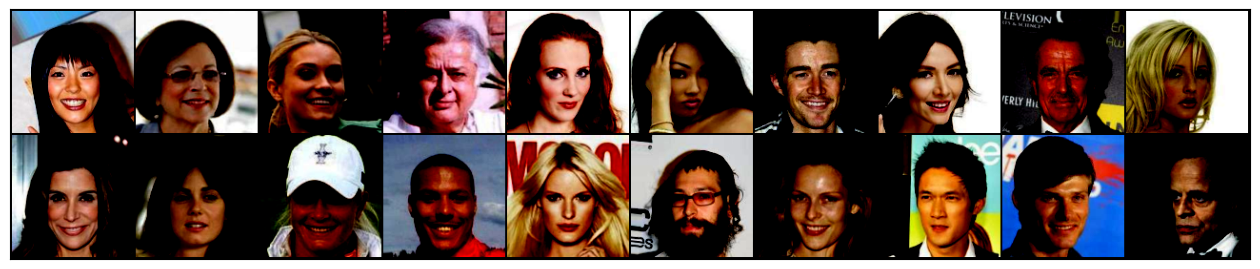

In [11]:
images, _ = next(iter(dataloader_train))
fig, ax = plt.subplots(figsize=(16, 10))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(images[:20], 10).permute(1, 2, 0));

In [12]:
class Residual(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_hiddens):
        super(Residual, self).__init__()
        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(in_channels=in_channels,
                      out_channels=num_residual_hiddens,
                      kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(in_channels=num_residual_hiddens,
                      out_channels=num_hiddens,
                      kernel_size=1, stride=1, bias=False)
        )
    
    def forward(self, x):
        return x + self._block(x)


class ResidualStack(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(ResidualStack, self).__init__()
        self._num_residual_layers = num_residual_layers
        self._layers = nn.ModuleList([Residual(in_channels, num_hiddens, num_residual_hiddens)
                             for _ in range(self._num_residual_layers)])

    def forward(self, x):
        for i in range(self._num_residual_layers):
            x = self._layers[i](x)
        return F.relu(x)

In [13]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Encoder, self).__init__()

        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens//2,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_2 = nn.Conv2d(in_channels=num_hiddens//2,
                                 out_channels=num_hiddens,
                                 kernel_size=4,
                                 stride=2, padding=1)
        self._conv_3 = nn.Conv2d(in_channels=num_hiddens,
                                 out_channels=num_hiddens,
                                 kernel_size=3,
                                 stride=1, padding=1)
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        x = F.relu(x)
        
        x = self._conv_2(x)
        x = F.relu(x)
        
        x = self._conv_3(x)
        return self._residual_stack(x)

In [14]:
summary(Encoder(3, num_hiddens, num_residual_layers, num_residual_hiddens).to('cpu'), input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,136
            Conv2d-2          [-1, 128, 32, 32]         131,200
            Conv2d-3          [-1, 128, 32, 32]         147,584
              ReLU-4          [-1, 128, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]          36,864
              ReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]           4,096
          Residual-8          [-1, 128, 32, 32]               0
              ReLU-9          [-1, 128, 32, 32]               0
           Conv2d-10           [-1, 32, 32, 32]          36,864
             ReLU-11           [-1, 32, 32, 32]               0
           Conv2d-12          [-1, 128, 32, 32]           4,096
         Residual-13          [-1, 128, 32, 32]               0
    ResidualStack-14          [-1, 128,

In [15]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, num_residual_layers, num_residual_hiddens):
        super(Decoder, self).__init__()
        
        self._conv_1 = nn.Conv2d(in_channels=in_channels,
                                 out_channels=num_hiddens,
                                 kernel_size=3, 
                                 stride=1, padding=1)
        
        self._residual_stack = ResidualStack(in_channels=num_hiddens,
                                             num_hiddens=num_hiddens,
                                             num_residual_layers=num_residual_layers,
                                             num_residual_hiddens=num_residual_hiddens)
        
        self._conv_trans_1 = nn.ConvTranspose2d(in_channels=num_hiddens, 
                                                out_channels=num_hiddens//2,
                                                kernel_size=4, 
                                                stride=2, padding=1)
        
        self._conv_trans_2 = nn.ConvTranspose2d(in_channels=num_hiddens//2, 
                                                out_channels=3,
                                                kernel_size=4, 
                                                stride=2, padding=1)

    def forward(self, inputs):
        x = self._conv_1(inputs)
        
        x = self._residual_stack(x)
        
        x = self._conv_trans_1(x)
        x = F.relu(x)
        
        return self._conv_trans_2(x)

In [16]:
summary(Decoder(num_hiddens, num_hiddens, num_residual_layers, num_residual_hiddens).to('cpu'), input_size=(128, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]         147,584
              ReLU-2          [-1, 128, 32, 32]               0
            Conv2d-3           [-1, 32, 32, 32]          36,864
              ReLU-4           [-1, 32, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]           4,096
          Residual-6          [-1, 128, 32, 32]               0
              ReLU-7          [-1, 128, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]          36,864
              ReLU-9           [-1, 32, 32, 32]               0
           Conv2d-10          [-1, 128, 32, 32]           4,096
         Residual-11          [-1, 128, 32, 32]               0
    ResidualStack-12          [-1, 128, 32, 32]               0
  ConvTranspose2d-13           [-1, 64, 64, 64]         131,136
  ConvTranspose2d-14          [-1, 3, 1

In [17]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [18]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

In [19]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens, 
                 num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()
        
        self._encoder = Encoder(3, num_hiddens,
                                num_residual_layers, 
                                num_residual_hiddens)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, 
                                      out_channels=embedding_dim,
                                      kernel_size=1, 
                                      stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, 
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        
        self._decoder = Decoder(embedding_dim,
                                num_hiddens, 
                                num_residual_layers, 
                                num_residual_hiddens)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity


In [20]:
model = Model(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

train_res_recon_error_list = []
train_res_perplexity_list = []
valid_res_recon_error_list = []
valid_res_perplexity_list = []

for epoch in range(1, n_epochs+1):

    train_res_recon_error = 0.0
    train_res_perplexity = 0.0
    valid_res_recon_error = 0.0
    valid_res_perplexity = 0.0

    model.train()

    for batch_idx, (batch, _) in enumerate(dataloader_train):

        batch = batch.to(device)
        optimizer.zero_grad()

        vq_loss, data_recon, perplexity = model(batch)
        recon_error = F.mse_loss(data_recon, batch) / data_variance
        loss = recon_error + vq_loss
        loss.backward()
        
        # gradient step
        optimizer.step()

        train_res_recon_error += (recon_error.item() - train_res_recon_error)/(batch_idx + 1)
        train_res_perplexity += (perplexity.item() - train_res_perplexity)/(batch_idx + 1)

    model.eval()

    for batch_idx, (batch, _) in enumerate(dataloader_valid):

        batch = batch.to(device)

        vq_loss, data_recon, perplexity = model(batch)
        recon_error = F.mse_loss(data_recon, batch) / data_variance
        loss = recon_error + vq_loss

        valid_res_recon_error += (recon_error.item() - valid_res_recon_error)/(batch_idx + 1)
        valid_res_perplexity += (perplexity.item() - valid_res_perplexity)/(batch_idx + 1)

    train_res_recon_error_list.append(train_res_recon_error)
    train_res_perplexity_list.append(train_res_perplexity)
    valid_res_recon_error_list.append(valid_res_recon_error)
    valid_res_perplexity_list.append(valid_res_perplexity)

    print("Epoch: {} \tTrain Recon Error: {:.6f} \tTrain Perplexity: {:.6f} \tVal Recon Error: {:.6f} \tVal Perplexity: {:.6f}".format(
        epoch, 
        train_res_recon_error,
        train_res_perplexity,
        valid_res_recon_error,
        valid_res_perplexity
        ))

Epoch: 1 	Train Recon Error: 0.184913 	Train Perplexity: 2.329975 	Val Recon Error: 0.118516 	Val Perplexity: 2.577801
Epoch: 2 	Train Recon Error: 0.157252 	Train Perplexity: 2.342486 	Val Recon Error: 0.172289 	Val Perplexity: 2.267470
Epoch: 3 	Train Recon Error: 0.136267 	Train Perplexity: 2.618857 	Val Recon Error: 0.149583 	Val Perplexity: 2.214204
Epoch: 4 	Train Recon Error: 0.089376 	Train Perplexity: 3.315686 	Val Recon Error: 0.064758 	Val Perplexity: 4.361547
Epoch: 5 	Train Recon Error: 0.051950 	Train Perplexity: 4.699721 	Val Recon Error: 0.056135 	Val Perplexity: 5.797004
Epoch: 6 	Train Recon Error: 0.049565 	Train Perplexity: 6.301780 	Val Recon Error: 0.044976 	Val Perplexity: 7.400635
Epoch: 7 	Train Recon Error: 0.040714 	Train Perplexity: 8.339170 	Val Recon Error: 0.037399 	Val Perplexity: 10.576287
Epoch: 8 	Train Recon Error: 0.034097 	Train Perplexity: 10.883539 	Val Recon Error: 0.029650 	Val Perplexity: 12.447077
Epoch: 9 	Train Recon Error: 0.027170 	Train 

In [ ]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_list, label="Train")
ax.plot(valid_res_recon_error_list, label="Validation")
ax.set_xlabel("Epochs")
ax.set_ylabel("NMSE")
ax.set_title('Reconstruction Error')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_list, label="Train")
ax.plot(valid_res_perplexity_list, label="Validation")
ax.set_xlabel("Epochs")
ax.set_ylabel("Perplexity")
ax.set_title('Average codebook usage (perplexity)');

In [ ]:
model.eval()

(valid_originals, _) = next(iter(dataloader_valid))
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

In [ ]:
(train_originals, _) = next(iter(dataloader_train))
train_originals = train_originals.to(device)
_, train_reconstructions, _, _ = model._vq_vae(train_originals)

In [ ]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

In [ ]:
show(make_grid(valid_reconstructions.cpu().data[:32,...])+0.5, )

In [ ]:
show(make_grid(valid_originals.cpu()[:32,...])+0.5)